# Рынок заведений общественного питания Москвы

Мы решили открыть небольшое кафе в Москве. <br>
Оно оригинальное — гостей должны обслуживать роботы. <br>
Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. <br>
Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? <br>
У нас есть открытые данные о заведениях общественного питания в Москве. <br>

## Шаг №1. Загрузим данные и подготовим их к анализу


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [ ]:
df = pd.read_csv('/datasets/rest_data.csv')
df.info()
print('duplicated sum:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
duplicated sum: 0


Столбец "chain" хотелось бы перевести в формат bool. <br>
Столбец "object_name" нужно фильтровать.

In [ ]:
df['chain'].replace(['да', 'нет'], [True, False], inplace=True)
df['object_name'] = df['object_name'].str.lower()
df['object_name'] = df['object_name'].replace(['[^A-zА-я ]', 'предприятие быстрого обслуживания',
                                               'lounge', 'кафе', 'ресторан', 'кофейня', 'лаунджбар', 'бар',
                                               'магазин готовой еды', 'предприятие быстрого питания', 'сеть магазинов',
                                               'каффе', 'закусочная', 'при азс', 'пбо', 'москва', 'суши', 'территория'
                                               'пицца', 'city', 'кулинарная лавка', 'буфет', 'азс', 'сеть городских',
                                               'пиццерия', 'мск', 'точка продажи готовой еды', 'мороженного', 'пекарея',
                                               'кальян', 'кальянная', 'паб', 'быстрого питания', 'готовые блюда',
                                               'fridays'
                                              ],'', regex=True)
df['object_name'] = df['object_name'].str.strip()


## Шаг №2. Анализ данных

### Исследуем соотношение видов объектов общественного питания по количеству.

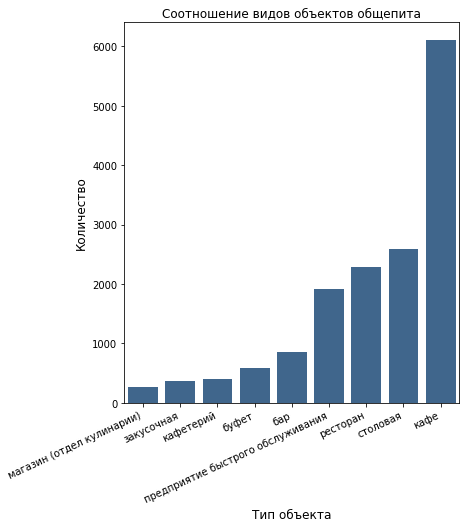

In [ ]:
plt.figure(figsize=(6, 7))
sns.barplot(
    x='object_type',
    y='id',
    data=df.groupby('object_type').agg({'id':'count'}).reset_index().sort_values('id', ascending=True),
    color=(0.2, 0.4, 0.6, 0.6)
)
plt.title('Cоотношение видов объектов общепита')
plt.xlabel('Тип объекта', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.xticks(rotation=25, ha='right')
plt.show()

В Москве кафешек так много, как всех остальных заведений вместе взятых.

### Исследуем соотношение сетевых и несетевых заведений по количеству.

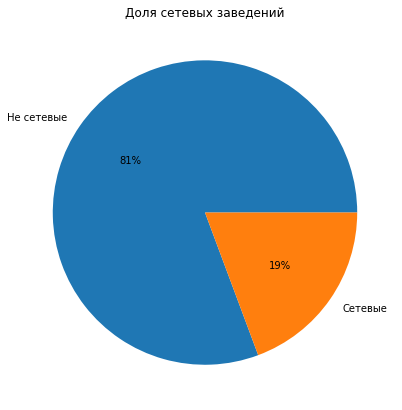

In [ ]:
plt.figure(figsize=(12, 7))
plt.pie(
    x='id',
    labels=['Не сетевые', 'Cетевые'],
    data=df.groupby('chain').agg({'id':'count'}).reset_index(),
    autopct='%.0f%%'
)
plt.title('Доля сетевых заведений')
plt.show()

Сетевых заведений 19%

### Определим для какого вида объекта общественного питания характерно сетевое распространение

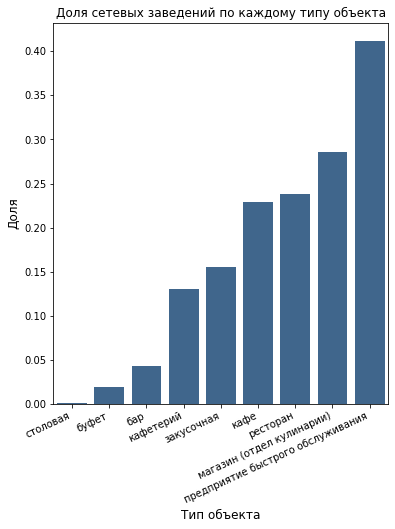

In [ ]:
test_df = df.pivot_table(
    index='object_type',
    columns='chain',
    values = 'id',
    aggfunc = 'count'
)

test_df['rate'] = test_df[True] / (test_df[False] + test_df[True])

plt.figure(figsize=(6, 7))
sns.barplot(
    x='object_type',
    y='rate',
    data=test_df.reset_index().sort_values('rate', ascending=True),
    color=(0.2, 0.4, 0.6, 0.6)

)
plt.title('Доля сетевых заведений по каждому типу объекта')
plt.xlabel('Тип объекта', fontsize = 12)
plt.ylabel('Доля', fontsize = 12)
plt.xticks(rotation=25, ha='right')
plt.show()

Доля сетевых заведений 40% у предприятий быстрого обслуживания! <br>
Для предприятий быстрого обслуживания характерно сетевое распространение.

### Выясним что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест

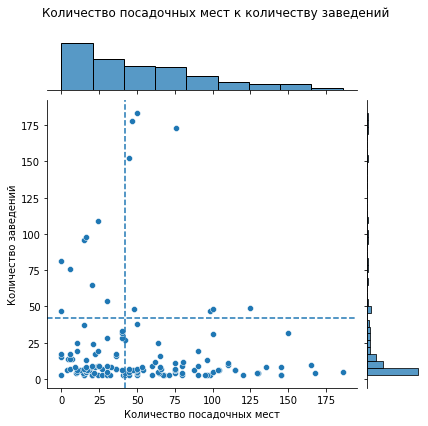

In [ ]:
tests = (df.query('chain == True').groupby('object_name')
         .agg({
             'id':'count',
             'number':'median'
         }).query('id > 2').sort_values('id').reset_index())

plot = sns.jointplot(x='number',
                     y='id',
                     data=tests)

plot.fig.suptitle('Количество посадочных мест к количеству заведений')
plot.fig.subplots_adjust(top=0.90)
plot.ax_joint.set_xlabel('Количество посадочных мест')
plot.ax_joint.set_ylabel('Количество заведений')
plot.ax_joint.axvline(tests['number'].median(), linestyle="--")
plot.ax_joint.axhline(tests['number'].median(), linestyle="--")

Мало мест и мало филиалов относительно медианных значений.

### Для каждого вида объекта посчитаем среднее количество посадочных мест.

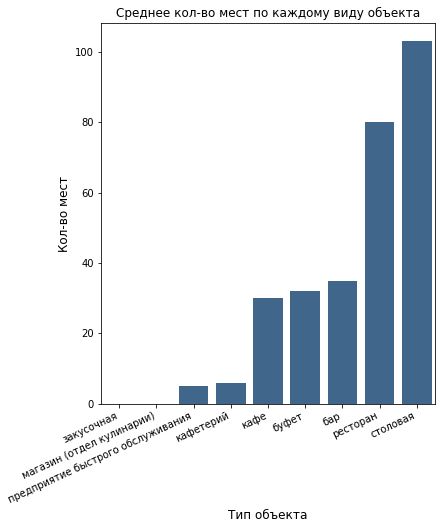

In [ ]:
plt.figure(figsize=(6, 7))
sns.barplot(
    x='object_type',
    y='number',
    data=(df.groupby('object_type').agg({'number': 'median'})
          .reset_index().sort_values('number', ascending=True)),
    color=(0.2, 0.4, 0.6, 0.6)

)
plt.title('Среднее кол-во мест по каждому виду объекта')
plt.xlabel('Тип объекта', fontsize = 12)
plt.ylabel('Кол-во мест', fontsize = 12)
plt.xticks(rotation=25, ha='right')
plt.show()

Все логично, закусочная работает на вынос, как и магазин. <br>
Лидер - столовка, по понятным причинам <br>

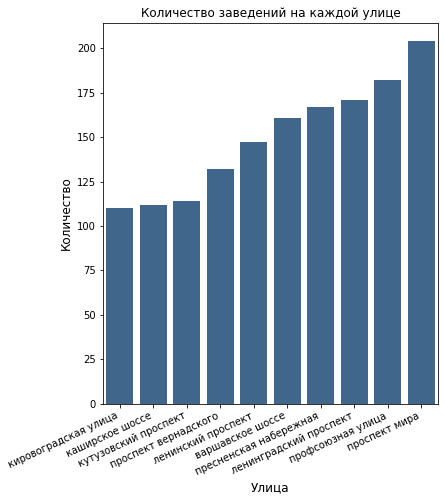

In [ ]:
df['street'] = [i[1] for i in df['address'].str.split(',')]
df['street'] = df['street'].str.lower()
df['street'] = df['street'].str.strip()
df['mask_street'] = df['street'].str.contains("^поселение|^город|^деревня")
data_street = (df.query('mask_street == False').groupby('street').agg({'id':'count'})
               .reset_index().sort_values('id', ascending=False).head(10).sort_values('id', ascending=True))


plt.figure(figsize=(6, 7))
sns.barplot(
    x='street',
    y='id',
    data=data_street,
    color=(0.2, 0.4, 0.6, 0.6)
)
plt.title('Количество заведений на каждой улице')
plt.xlabel('Улица', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.xticks(rotation=25, ha='right')
plt.show()

In [ ]:
r = requests.get('https://drive.google.com/uc?id=10HNxLhllKVu0QFP0QlUsdFDvd-h0dqGK&export=download')

street_msc = pd.read_csv(BytesIO(r.content))
street_msc['streetname'] = street_msc['streetname'].str.lower()

In [ ]:
data_street.merge(
    street_msc,
    left_on='street',
    right_on='streetname'
).groupby('street').agg({
    'area':'unique',
    'okrug':'unique'
})

,area,okrug
street,,
варшавское шоссе,"[Район Чертаново Центральное, Район Чертаново ...","[ЮАО, ЮЗАО]"
каширское шоссе,"[Район Москворечье-Сабурово, Район Нагатино-Са...",[ЮАО]
кировоградская улица,"[Район Чертаново Центральное, Район Чертаново ...",[ЮАО]
кутузовский проспект,"[Район Дорогомилово, Район Фили-Давыдково]",[ЗАО]
ленинградский проспект,"[Район Аэропорт, Район Беговой, Хорошевский ра...",[САО]
ленинский проспект,"[Район Проспект Вернадского, Район Тропарево-Н...","[ЗАО, ЮАО, ЮЗАО, ЦАО]"
пресненская набережная,[Пресненский район],[ЦАО]
проспект вернадского,"[Район Проспект Вернадского, Район Раменки, Ра...","[ЗАО, ЮЗАО]"
проспект мира,"[Алексеевский район, Ярославский Район, Район ...","[СВАО, ЦАО]"


никакой связи нету, эти улицы просто протяженные. <br>
В разных районах <br>

### Найдем число улиц с одним объектом общественного питания.

In [ ]:
df.query('mask_street == False').groupby('street').agg({'id':'count'}).reset_index().query('id == 1').merge(
    street_msc,
    left_on='street',
    right_on='streetname'
).groupby('street').agg({
    'area':'unique',
    'okrug':'unique'
}).reset_index()

,street,area,okrug
0,1-й балтийский переулок,[Район Аэропорт],[САО]
1,1-й басманный переулок,"[Басманный район, Красносельский район]",[ЦАО]
2,1-й ботанический проезд,[Район Свиблово],[СВАО]
3,1-й вешняковский проезд,[Рязанский район],[ЮВАО]
4,1-й голутвинский переулок,[Район Якиманка],[ЦАО]
...,...,...,...
511,ялтинская улица,[Нагорный район],[ЮАО]
512,янтарный проезд,[Лосиноостровский район],[СВАО]
513,ясногорская улица,[Район Ясенево],[ЮЗАО]
514,яузский бульвар,[Таганский район],[ЦАО]


753 улицы с 1 заведением. Аналогично, связь лишь в том, что эти улицы короткие.

### Общий вывод и  рекомендации

ВЫВОД:
Выводы делать крайне сложно по имеющимся данным, тем более что в данных нету никаких намеков на рентабельность этих заведений.<br>
Много заведений с малым количеством посадочных мест, а так же с малым количеством филиалов. <br>
Самый чатый тип заведения - кафе. Самый редкий - закусочная.<br>